<a href="https://colab.research.google.com/github/Shudh1999/CANCER/blob/main/notebook0972d410bd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,LeakyReLU,BatchNormalization
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Conv2D, Conv2DTranspose,DepthwiseConv2D
from keras.layers import MaxPooling2D, GlobalMaxPool2D, Concatenate
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from tqdm import tqdm
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip "/content/drive/MyDrive/cancer detection/brain_tumor.zip"

Archive:  /content/drive/MyDrive/cancer detection/brain_tumor.zip
replace brain_tumor/images/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!unzip "/content/drive/MyDrive/cancer detection/braintumor detection.zip"

Archive:  /content/drive/MyDrive/cancer detection/braintumor detection.zip
replace braintumor detection/Testing/glioma/Te-gl_0010.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
im_width = 256
im_height = 256
ids1 = next(os.walk("/content/brain_tumor/images"))[2]
X = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)

for n, id_ in tqdm(enumerate(ids1), total=len(ids1)):
    # Corrected paths to include a forward slash before the filename
    img_path = os.path.join("/content/brain_tumor/images", id_)
    mask_path = os.path.join("/content/brain_tumor/masks", id_)

    # Load images
    img = load_img(img_path, color_mode='grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode='constant', preserve_range=True)

    # Load masks
    mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
    mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)

    # Save images and masks
    X[n] = x_img / 255.0
    y[n] = mask / 255.0


100%|██████████| 3064/3064 [01:23<00:00, 36.68it/s]


In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,shuffle=True)


In [7]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [8]:
def CNN(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="CNN")
    return model

model = CNN((256,256,1))
model.summary()

Model: "CNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]'

In [9]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])



In [10]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10)



Epoch 1/10
154/154 [==============================] - 181s 869ms/step - loss: 0.1444 - accuracy: 0.9650
Epoch 2/10
154/154 [==============================] - 126s 821ms/step - loss: 0.0687 - accuracy: 0.9812
Epoch 3/10
154/154 [==============================] - 128s 831ms/step - loss: 0.0506 - accuracy: 0.9829
Epoch 4/10
154/154 [==============================] - 130s 842ms/step - loss: 0.0425 - accuracy: 0.9841
Epoch 5/10
154/154 [==============================] - 129s 841ms/step - loss: 0.0371 - accuracy: 0.9849
Epoch 6/10
154/154 [==============================] - 130s 843ms/step - loss: 0.0332 - accuracy: 0.9857
Epoch 7/10
154/154 [==============================] - 130s 841ms/step - loss: 0.0304 - accuracy: 0.9862
Epoch 8/10
154/154 [==============================] - 130s 843ms/step - loss: 0.0284 - accuracy: 0.9868
Epoch 9/10
154/154 [==============================] - 130s 841ms/step - loss: 0.0258 - accuracy: 0.9874
Epoch 10/10
154/154 [==============================] - 130s 845m

In [11]:
model.save('bestsegmentationmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Predict masks on test data
y_pred = model.predict(X_test)

# Convert predicted masks to binary values
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test = (y_test > 0.5).astype(np.uint8)

20/20 [==============================] - 41s 888ms/step - loss: 0.0306 - accuracy: 0.9864
Test Accuracy: 0.9863729476928711
20/20 [==============================] - 11s 544ms/step


20/20 [==============================] - 11s 524ms/step - loss: 0.0303 - accuracy: 0.9897
Test Loss: 0.030278393998742104
Test Accuracy: 0.9897450804710388


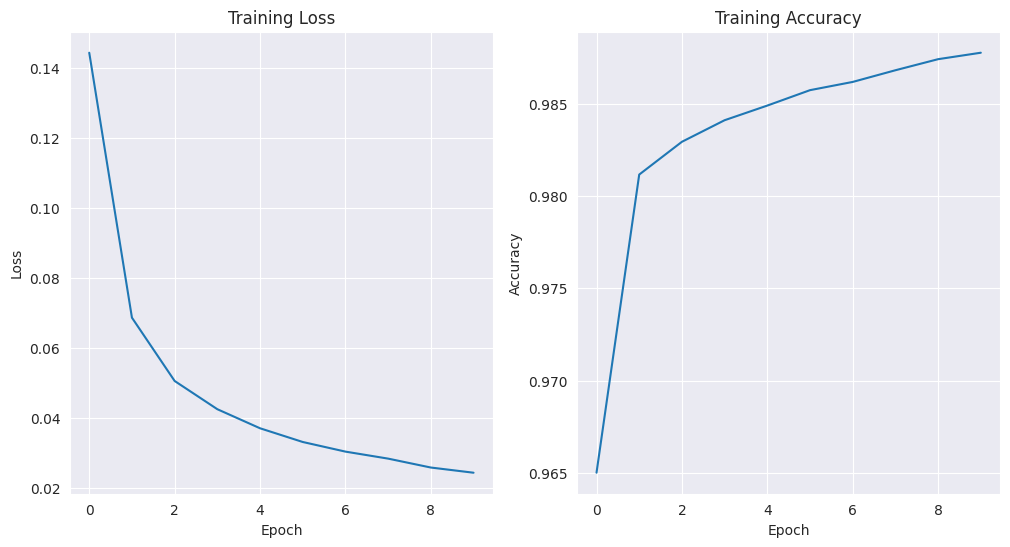

In [13]:
import matplotlib.pyplot as plt

# Assuming you have the loss and accuracy from evaluating your model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot the accuracy and loss
plt.figure(figsize=(12, 6))

# Plot test loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()


creating our model

In [14]:
train_data_dir = '/content/braintumor detection/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)


In [15]:
test_data_dir = '/content/braintumor detection/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)


In [16]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [17]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [18]:
from tensorflow.keras.models import Sequential
import keras
# model sequential
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= (224,224,3)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(4, activation = "softmax")
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_22 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [19]:
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])


prepaaring our data through data genrator

In [20]:
#early stoping condition dont want to waste the resources
from keras.callbacks import ModelCheckpoint, EarlyStopping
# early stopping
es=EarlyStopping(monitor="val_accuracy", min_delta= 0.01, patience= 5, verbose=1, mode = 'auto')
# model check point
mc=ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose=1, save_best_only= True, mode = 'auto')
cd=[es,mc]

model training

In [21]:
history = model.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False,callbacks=cd)


Epoch 1/10
357/357 [==============================] - ETA: 0s - loss: 1.8094 - accuracy: 0.6099
Epoch 1: val_accuracy improved from -inf to 0.69313, saving model to ./bestmodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


357/357 [==============================] - 93s 218ms/step - loss: 1.8094 - accuracy: 0.6099 - val_loss: 0.7051 - val_accuracy: 0.6931
Epoch 2/10
357/357 [==============================] - ETA: 0s - loss: 0.5064 - accuracy: 0.8004
Epoch 2: val_accuracy improved from 0.69313 to 0.77405, saving model to ./bestmodel.h5
357/357 [==============================] - 72s 201ms/step - loss: 0.5064 - accuracy: 0.8004 - val_loss: 0.5896 - val_accuracy: 0.7740
Epoch 3/10
357/357 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8613
Epoch 3: val_accuracy improved from 0.77405 to 0.83206, saving model to ./bestmodel.h5
357/357 [==============================] - 72s 203ms/step - loss: 0.3717 - accuracy: 0.8613 - val_loss: 0.4303 - val_accuracy: 0.8321
Epoch 4/10
357/357 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.9042
Epoch 4: val_accuracy improved from 0.83206 to 0.85038, saving model to ./bestmodel.h5
357/357 [==============================] - 73s 20

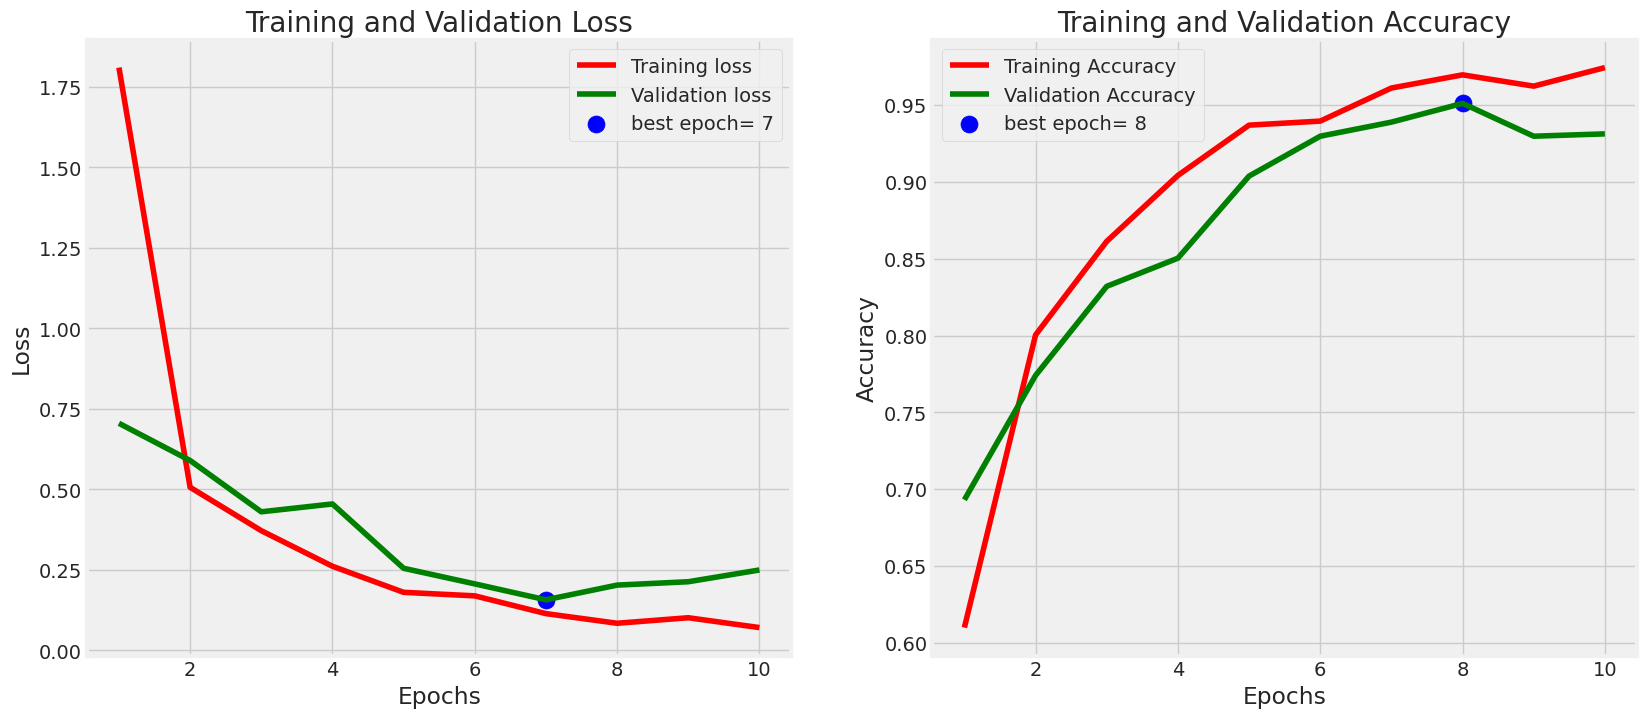

In [22]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [23]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 3s 60ms/step - loss: 0.2658 - accuracy: 0.9146
Train Loss:  0.0649552196264267
Train Accuracy:  0.9789915680885315
--------------------
Validation Loss:  0.249717578291893
Validation Accuracy:  0.9312977194786072
--------------------
Test Loss:  0.2658196985721588
Test Accuracy:  0.9146341681480408


In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [656, 613]

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
model.save('Brain Tumors.h5')


In [ ]:
loaded_model = tf.keras.models.load_model('/content/Brain Tumors.h5', compile=False)
loaded_model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/braintumor detection/Testing/glioma/Te-glTr_0002.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
print(f"{class_labels[np.argmax(predictions)]}")

In [ ]:
image_path = '/content/braintumor detection/Testing/pituitary/Te-piTr_0003.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
print(f"{class_labels[np.argmax(predictions)]}")